<a href="https://colab.research.google.com/github/EChoudhury/RealTimeAI/blob/main/RealTimeAIHW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
lossVal = torch.zeros(15)
epochNum = torch.zeros(15)
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [4]:
def model(t_u, w1, w2, b):
    return (w2 * (t_u**2)) + (w1 * t_u) + b

In [5]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [6]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

In [7]:
def dmodel_dw2(t_u, w1, w2, b):
    return t_u**2

In [8]:
def dmodel_dw1(t_u, w1, w2, b):
    return t_u

In [9]:
def dmodel_db(t_u, w1, w2, b):
    return 1.0

In [10]:
def grad_fn(t_u, t_c, t_p, w1, w2, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw2 = dloss_dtp * dmodel_dw2(t_u, w1, w2, b)
    dloss_dw1 = dloss_dtp * dmodel_dw1(t_u, w1, w2, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w1, w2, b)
    return torch.stack([dloss_dw2.sum(), dloss_dw1.sum(), dloss_db.sum()])  # <1>

In [11]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    i = 0
    for epoch in range(1, n_epochs + 1):
        w2, w1, b = params

        t_p = model(t_u, w1, w2, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w1, w2, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 4, 5, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            epochNum[i] = epoch
            lossVal[i] = float(loss)
            i += 1
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        #if epoch in {4, 12, 101}:
         #   print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [12]:
t_un = 0.01 * t_u

In [13]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([0.0, 0.0, 0.0]), 
    t_u = t_un,
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 187.386368
Epoch 2, Loss 180.390076
Epoch 3, Loss 173.766586
Epoch 4, Loss 167.495758
Epoch 5, Loss 161.558609
Epoch 10, Loss 136.280563
Epoch 11, Loss 131.999573
Epoch 99, Loss 51.684738
Epoch 100, Loss 51.576260
Epoch 4000, Loss 2.185927
Epoch 5000, Loss 2.109932


tensor([ 27.9093,  24.3089, -10.2858])

In [14]:
def training_loop(n_epochs, optimizer, learning_rate, params, t_u, t_c,
                  print_params=True):
    i = 0
    for epoch in range(1, n_epochs + 1):
        w2, w1, b = params

        t_p = model(t_u, w1, w2, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w1, w2, b)  # <2>
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch in {1, 2, 3, 4, 5, 10, 11, 99, 100, 200, 500, 1000, 2500,
                     4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            epochNum[i] = epoch
            lossVal[i] = float(loss)
            i += 1
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        #if epoch in {4, 12, 101}:
         #   print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
 
    return params

In [15]:
params = torch.tensor([1.0,1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer=optimizer,
    learning_rate = 1e-2, 
    params = params, 
    t_u = t_un,
    t_c = t_c)

Epoch 1, Loss 165.449524
    Params: tensor([1.0847, 1.1270, 0.1938], requires_grad=True)
    Grad:   tensor([ -8.4735, -12.6975, -19.3758], grad_fn=<StackBackward>)
Epoch 2, Loss 159.447083
    Params: tensor([1.1677, 1.2509, 0.3818], requires_grad=True)
    Grad:   tensor([ -8.2948, -12.3919, -18.8069], grad_fn=<StackBackward>)
Epoch 3, Loss 153.764099
    Params: tensor([1.2489, 1.3718, 0.5644], requires_grad=True)
    Grad:   tensor([ -8.1209, -12.0945, -18.2536], grad_fn=<StackBackward>)
Epoch 4, Loss 148.383392
    Params: tensor([1.3284, 1.4899, 0.7415], requires_grad=True)
    Grad:   tensor([ -7.9518, -11.8052, -17.7155], grad_fn=<StackBackward>)
Epoch 5, Loss 143.288559
    Params: tensor([1.4063, 1.6051, 0.9134], requires_grad=True)
    Grad:   tensor([ -7.7872, -11.5239, -17.1921], grad_fn=<StackBackward>)
Epoch 10, Loss 121.591576
    Params: tensor([1.7725, 2.1417, 1.6994], requires_grad=True)
    Grad:   tensor([ -7.0289, -10.2278, -14.7828], grad_fn=<StackBackward>)
Epo

tensor([ 27.9050,  24.3412, -10.3017], requires_grad=True)

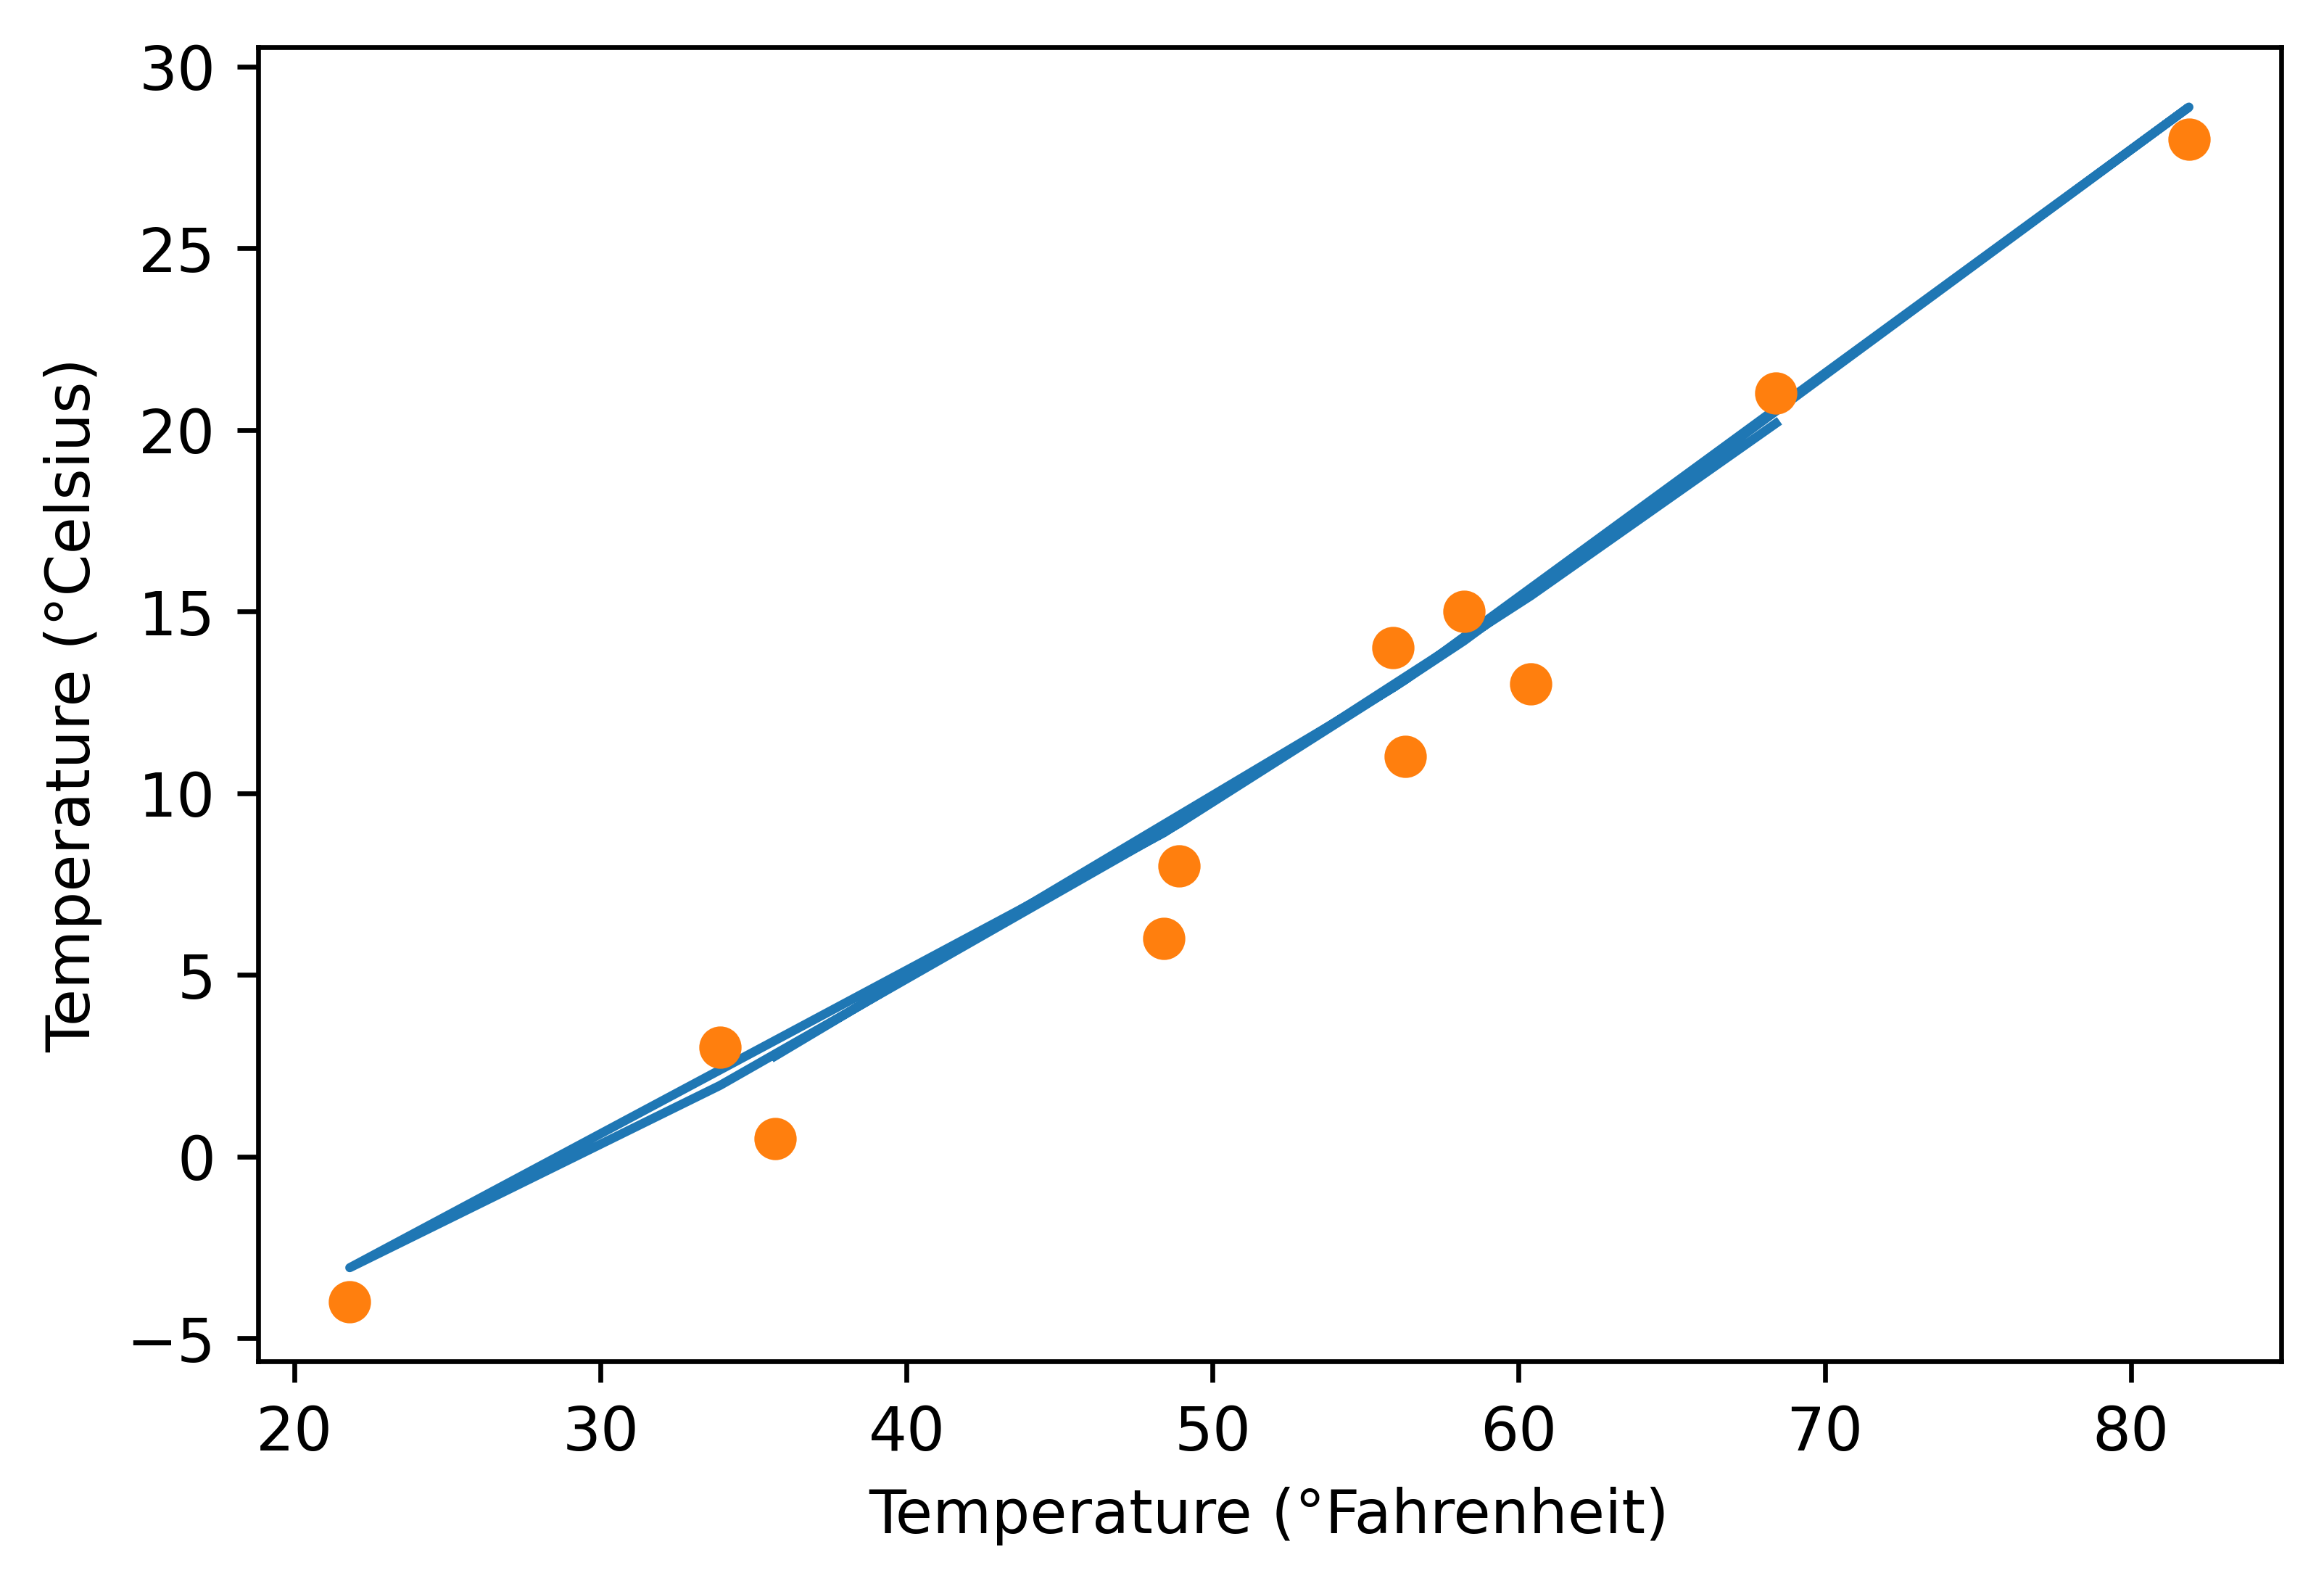

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

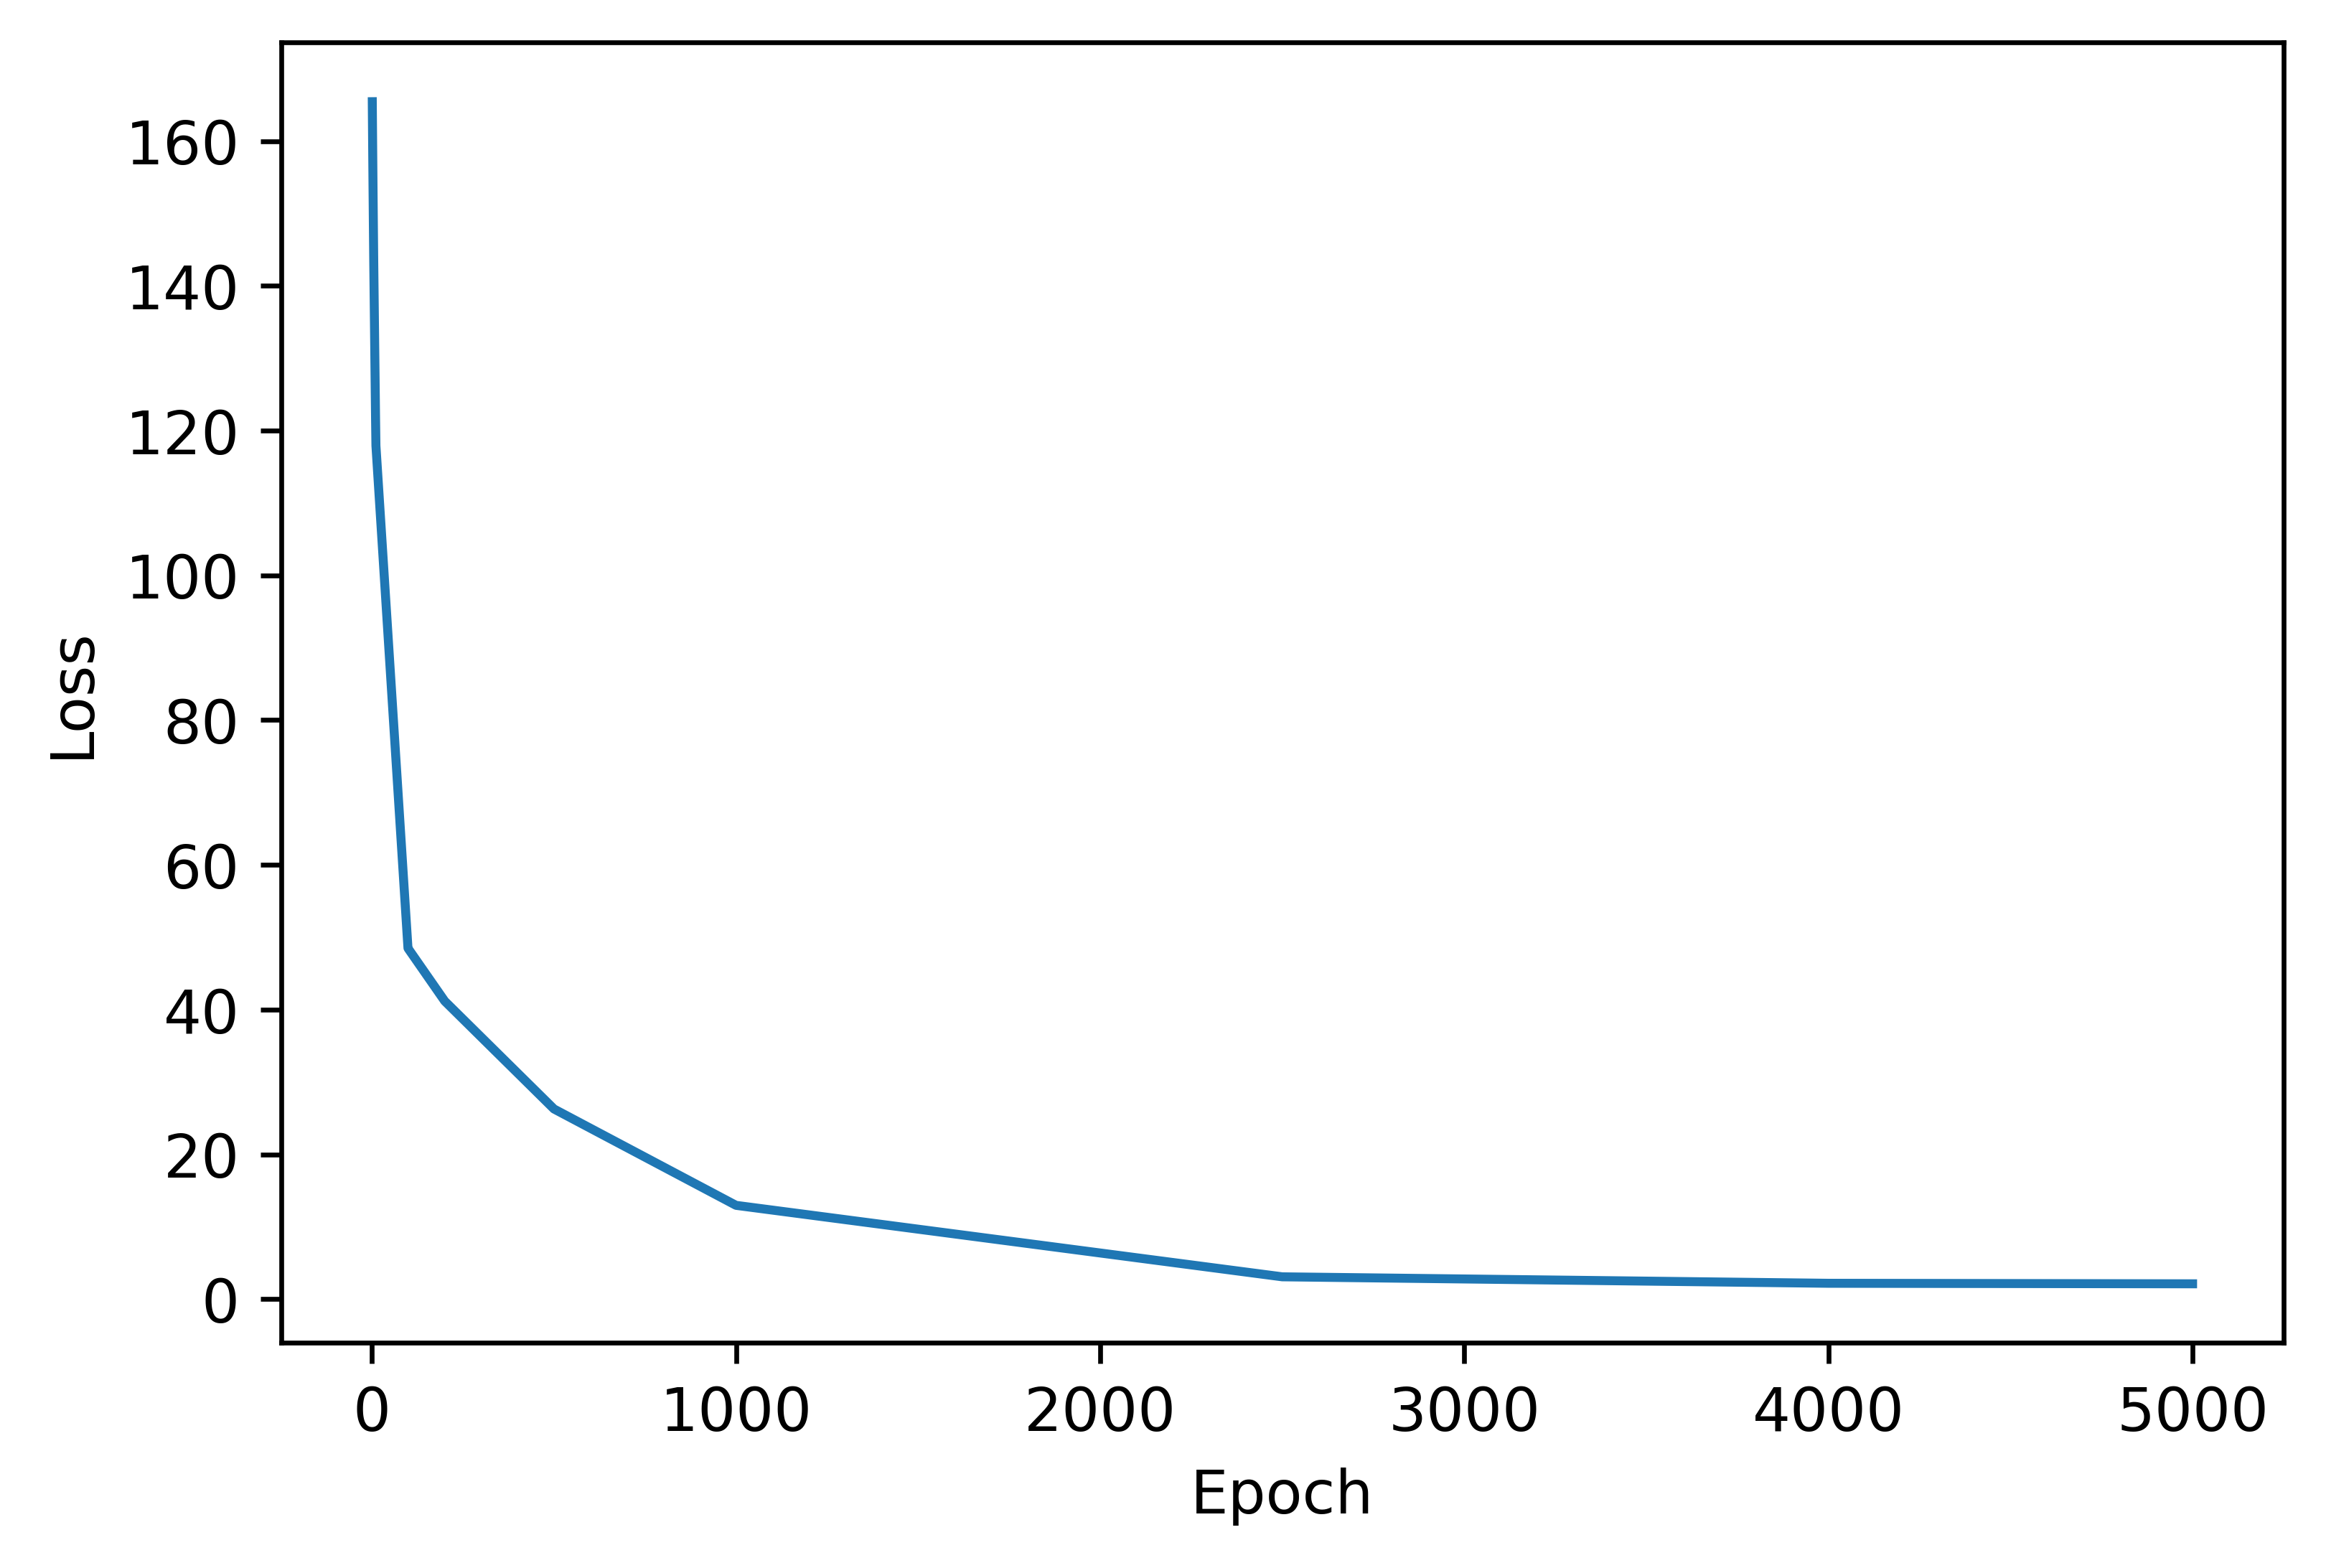

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochNum.numpy(), lossVal.numpy())

plt.savefig("temp_data_plot.png", format="png")

In [18]:
params = torch.tensor([1.0,1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer=optimizer,
    learning_rate = 1e-2, 
    params = params, 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 165.449524
    Params: tensor([1.0100, 1.0100, 0.0100], requires_grad=True)
    Grad:   tensor([ -8.4735, -12.6975, -19.3758], grad_fn=<StackBackward>)
Epoch 2, Loss 165.044373
    Params: tensor([1.0200, 1.0200, 0.0200], requires_grad=True)
    Grad:   tensor([ -8.4618, -12.6777, -19.3396], grad_fn=<StackBackward>)
Epoch 3, Loss 164.639938
    Params: tensor([1.0300, 1.0300, 0.0300], requires_grad=True)
    Grad:   tensor([ -8.4500, -12.6579, -19.3034], grad_fn=<StackBackward>)
Epoch 4, Loss 164.236221
    Params: tensor([1.0400, 1.0400, 0.0400], requires_grad=True)
    Grad:   tensor([ -8.4383, -12.6381, -19.2671], grad_fn=<StackBackward>)
Epoch 5, Loss 163.833191
    Params: tensor([1.0500, 1.0500, 0.0500], requires_grad=True)
    Grad:   tensor([ -8.4266, -12.6183, -19.2309], grad_fn=<StackBackward>)
Epoch 10, Loss 161.829346
    Params: tensor([1.1000, 1.0999, 0.0999], requires_grad=True)
    Grad:   tensor([ -8.3679, -12.5193, -19.0498], grad_fn=<StackBackward>)
Epo

tensor([27.2414, 19.8351, -7.6692], requires_grad=True)

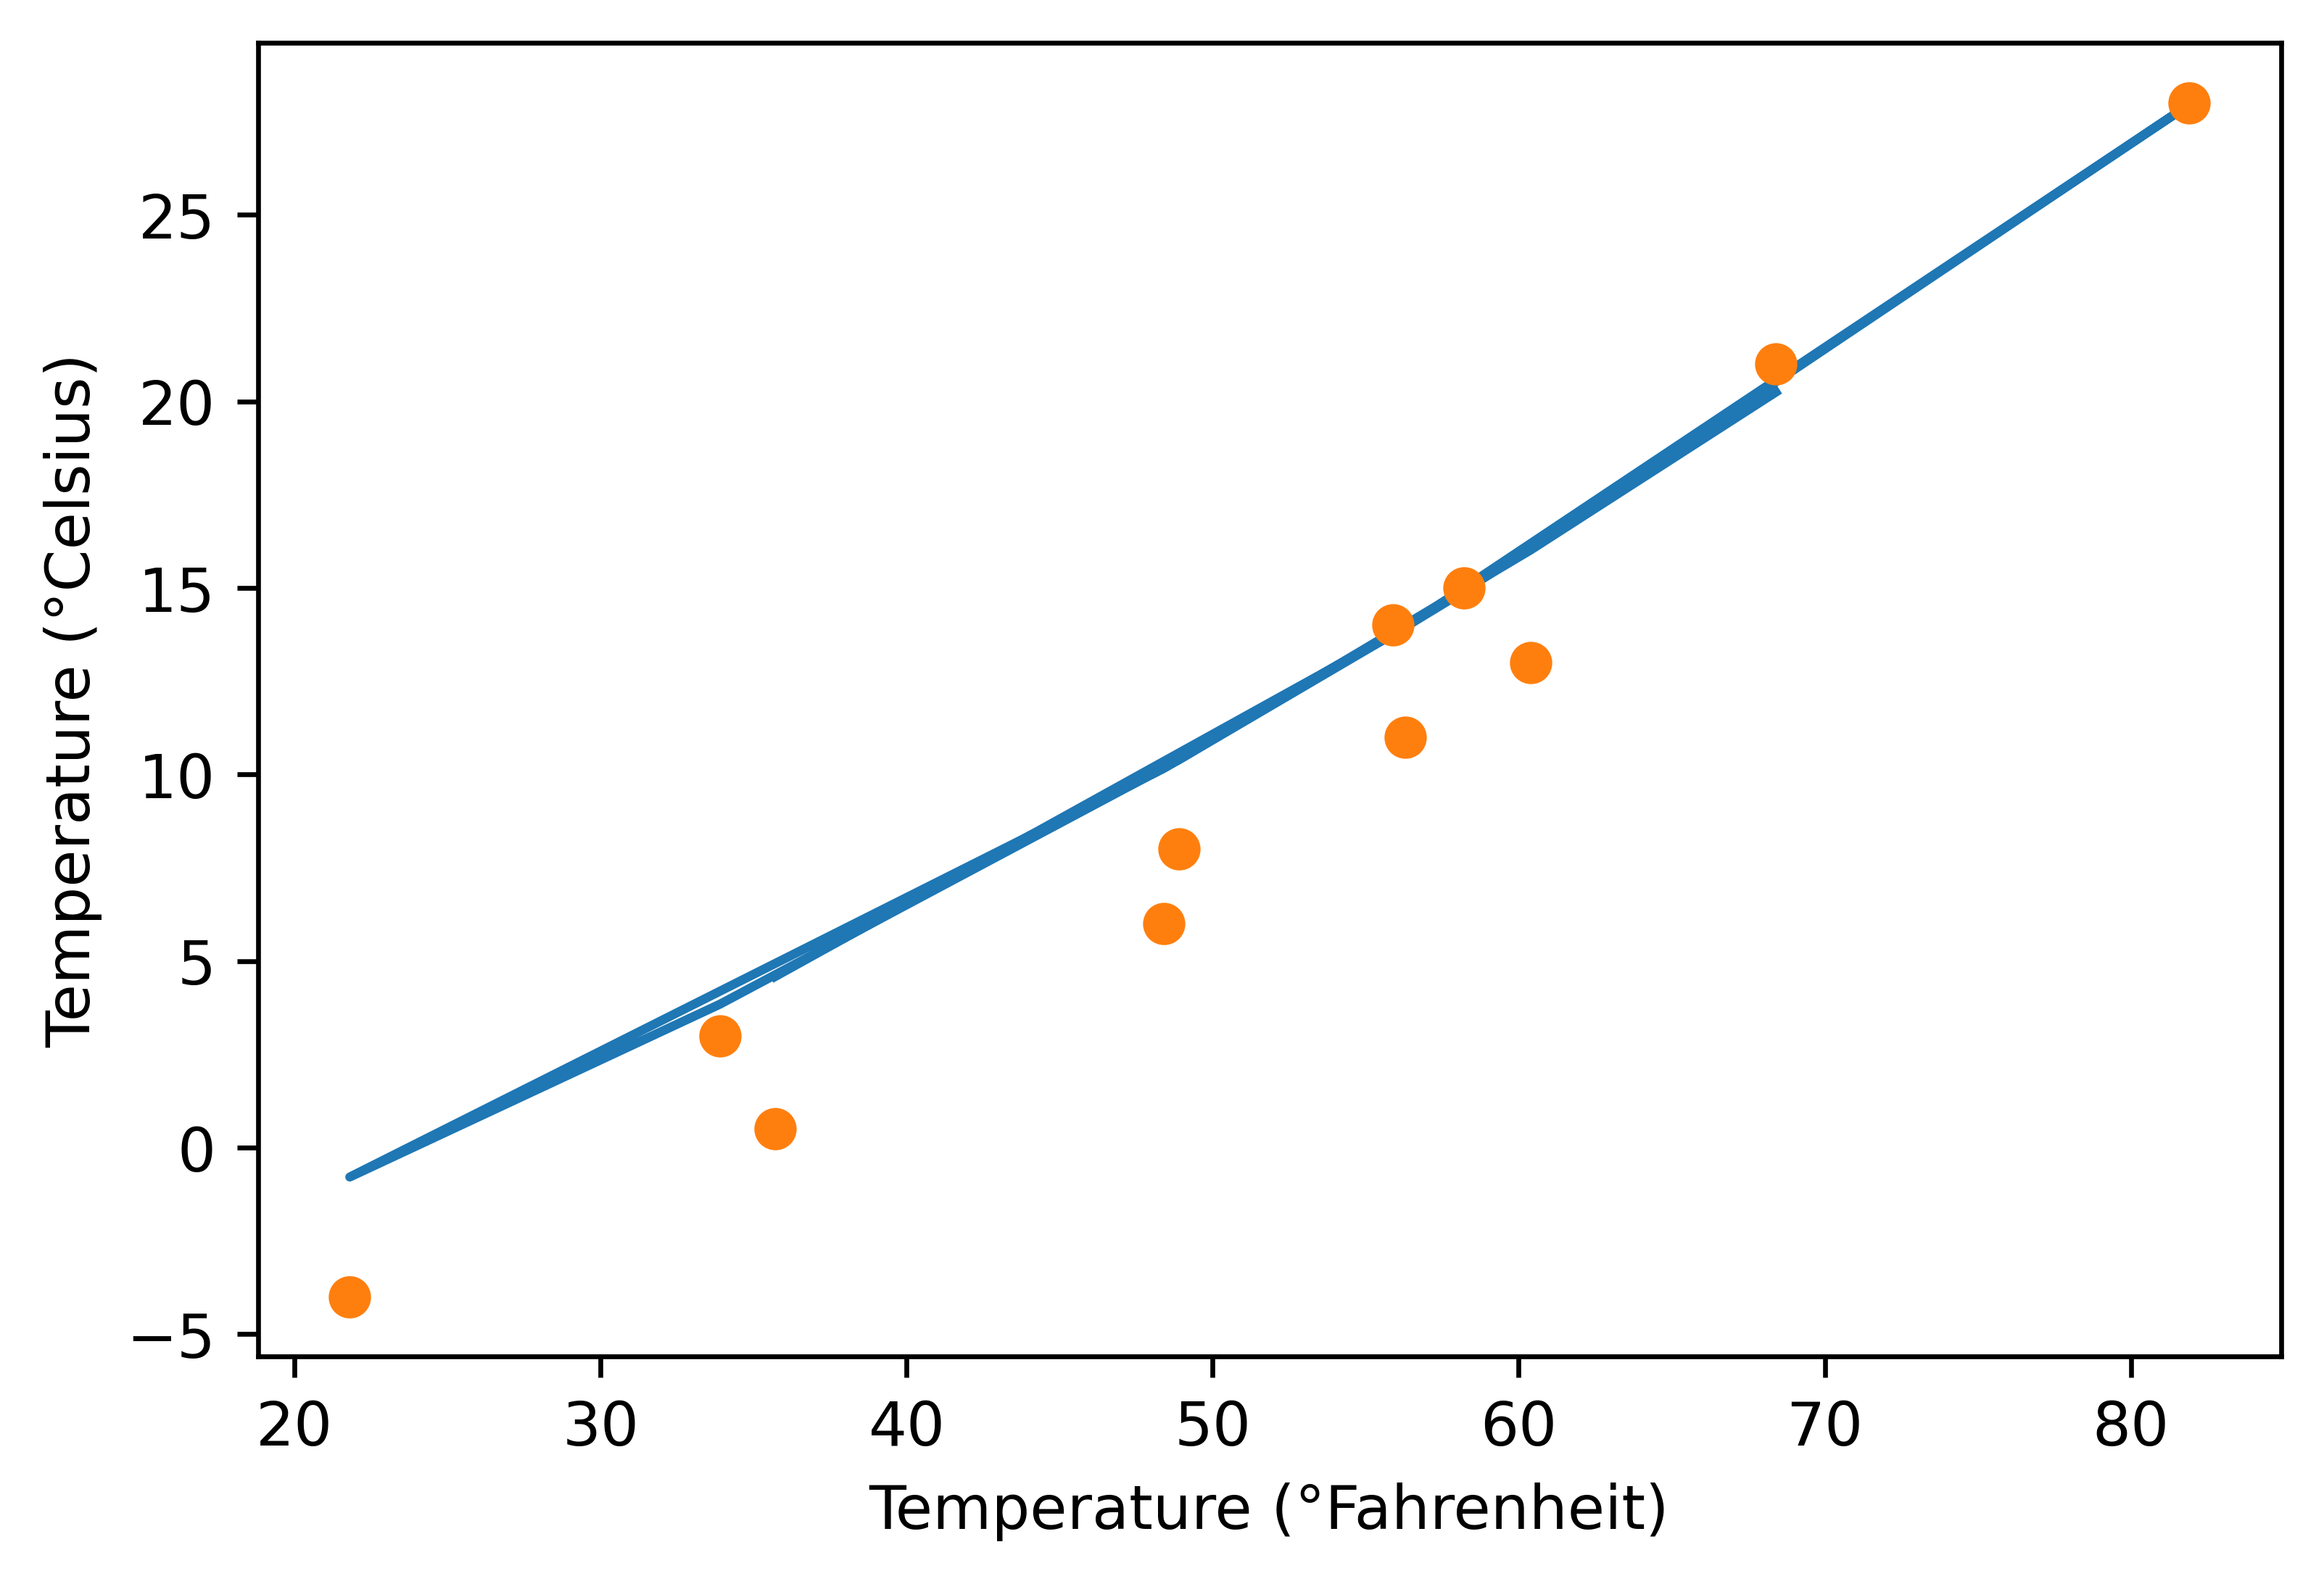

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

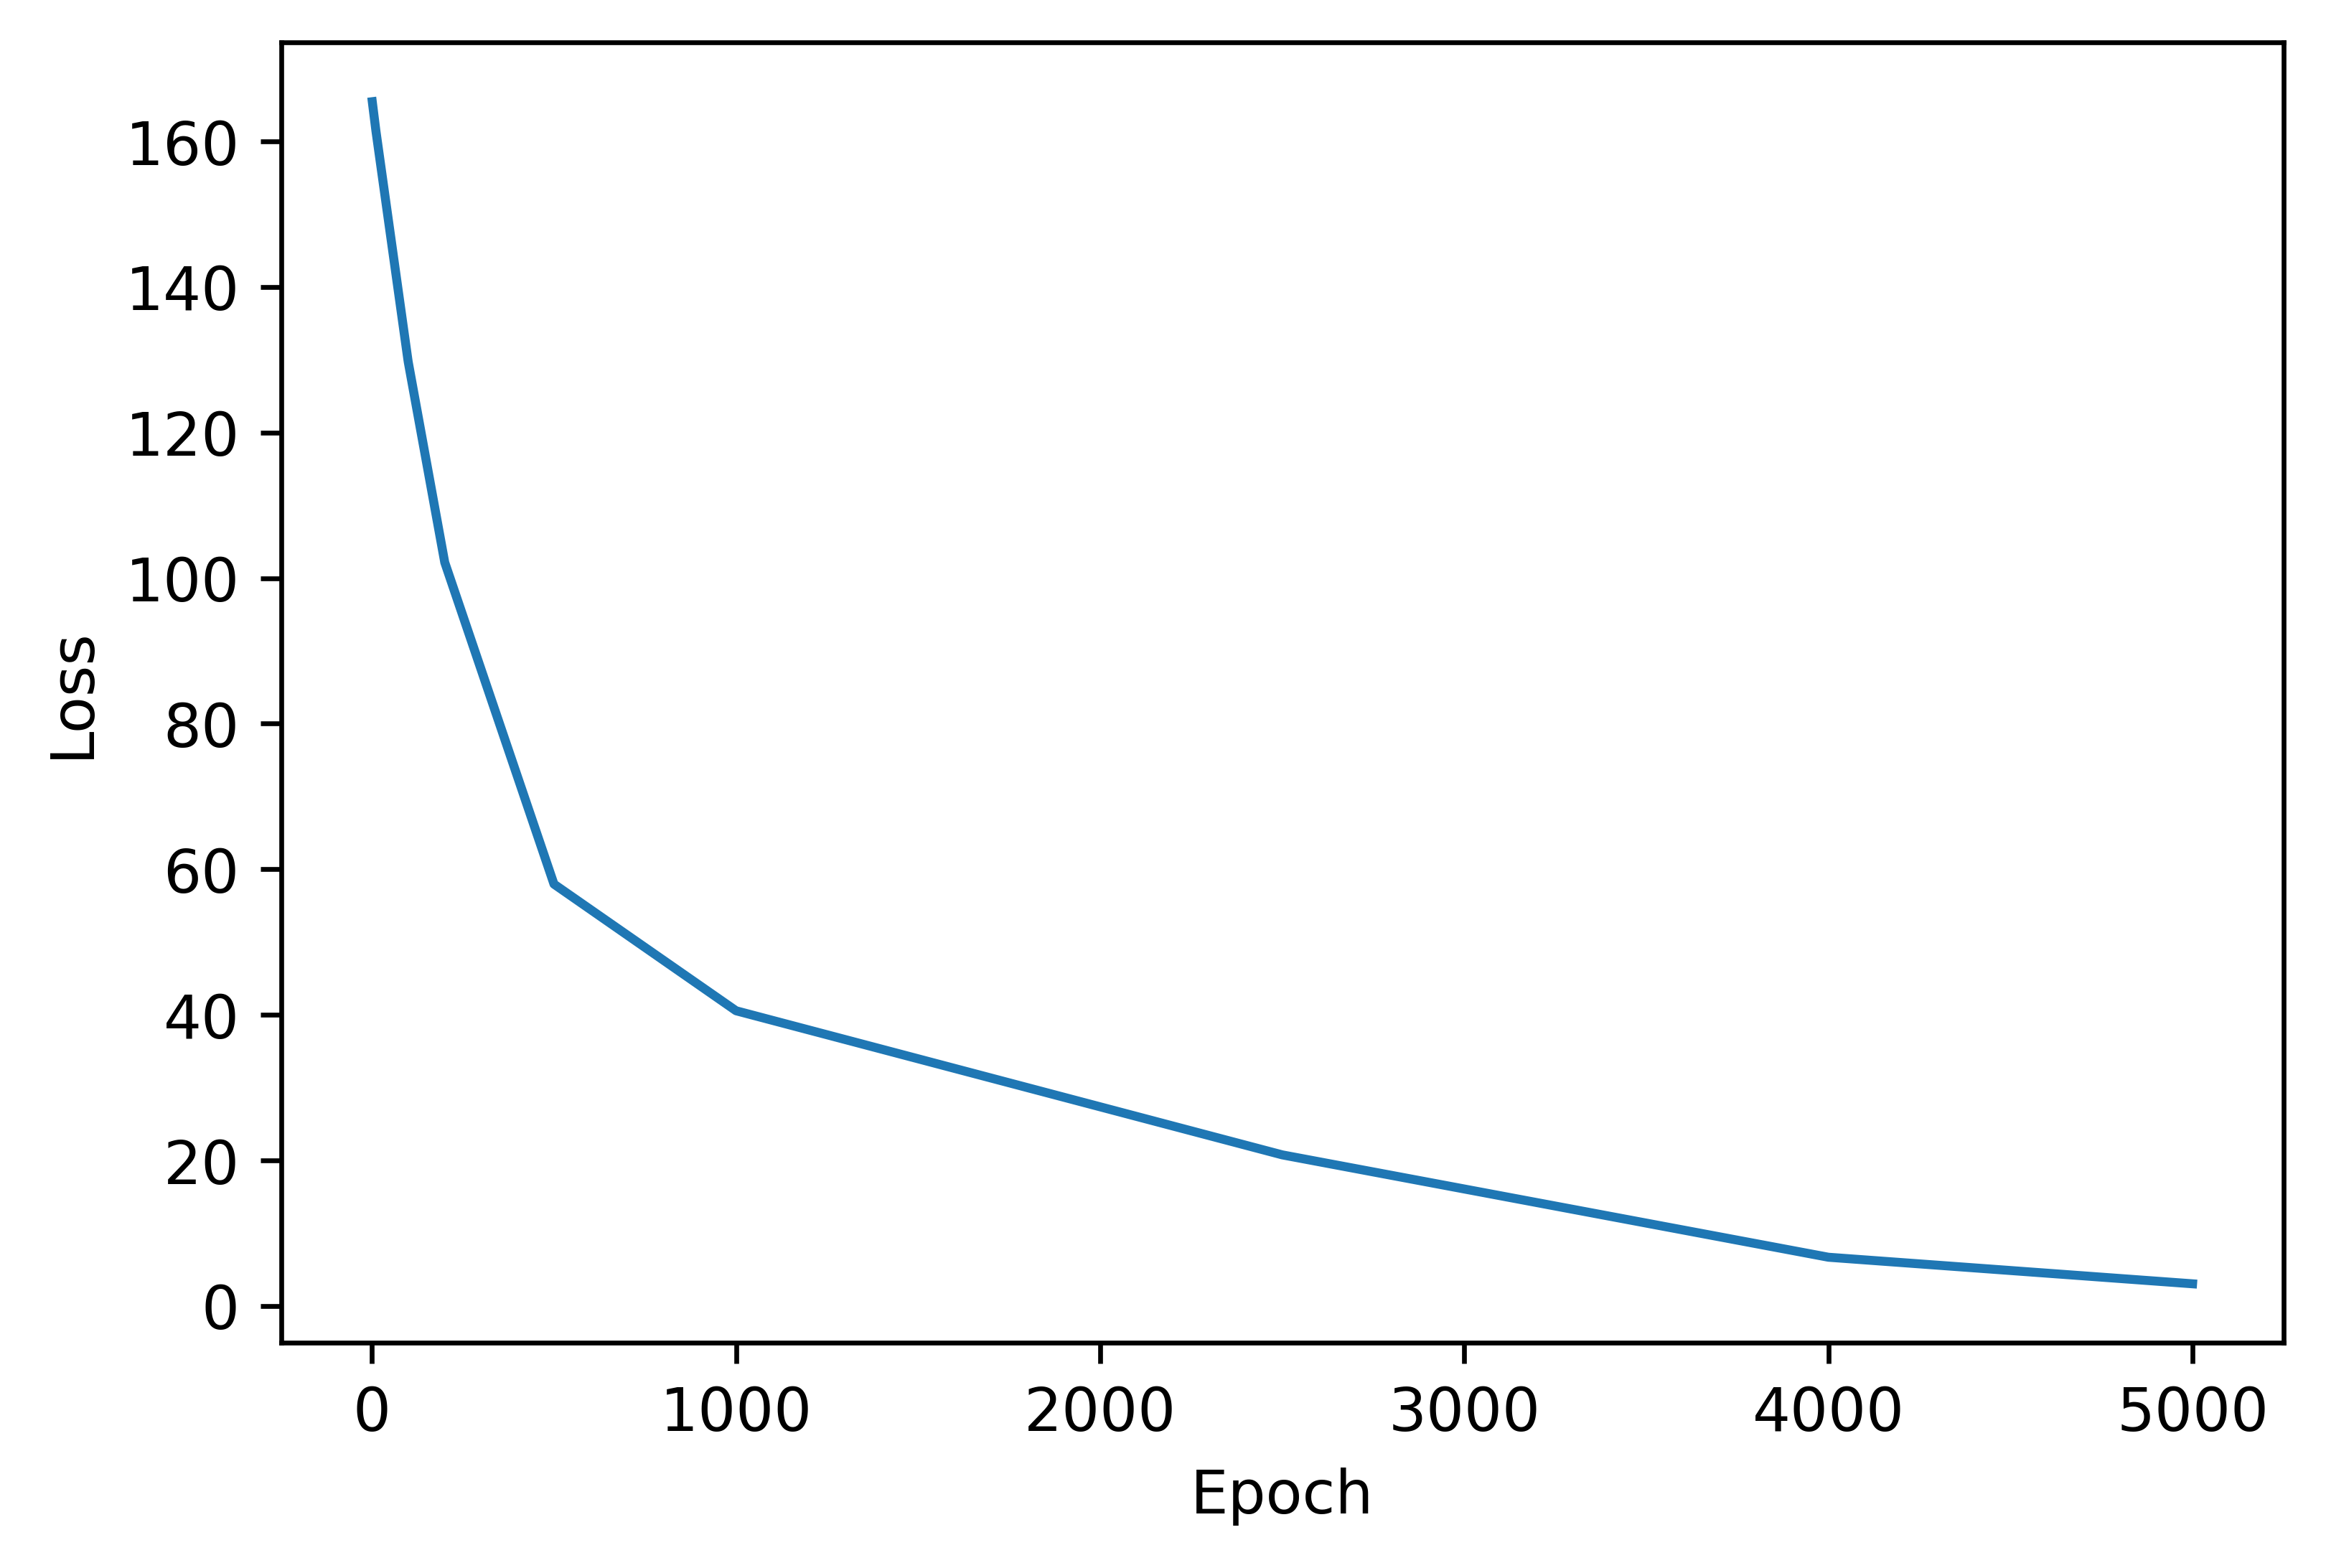

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochNum.numpy(), lossVal.numpy())

plt.savefig("temp_data_plot.png", format="png")

In [21]:
params = torch.tensor([1.0,1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adagrad([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer=optimizer,
    learning_rate = 1e-2, 
    params = params, 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 165.449524
    Params: tensor([1.0100, 1.0100, 0.0100], requires_grad=True)
    Grad:   tensor([ -8.4735, -12.6975, -19.3758], grad_fn=<StackBackward>)
Epoch 2, Loss 165.044373
    Params: tensor([1.0171, 1.0171, 0.0171], requires_grad=True)
    Grad:   tensor([ -8.4618, -12.6777, -19.3396], grad_fn=<StackBackward>)
Epoch 3, Loss 164.758545
    Params: tensor([1.0228, 1.0228, 0.0228], requires_grad=True)
    Grad:   tensor([ -8.4535, -12.6637, -19.3140], grad_fn=<StackBackward>)
Epoch 4, Loss 164.525558
    Params: tensor([1.0278, 1.0278, 0.0278], requires_grad=True)
    Grad:   tensor([ -8.4467, -12.6523, -19.2931], grad_fn=<StackBackward>)
Epoch 5, Loss 164.324036
    Params: tensor([1.0323, 1.0323, 0.0323], requires_grad=True)
    Grad:   tensor([ -8.4409, -12.6424, -19.2750], grad_fn=<StackBackward>)
Epoch 10, Loss 163.552231
    Params: tensor([1.0501, 1.0501, 0.0501], requires_grad=True)
    Grad:   tensor([ -8.4184, -12.6045, -19.2056], grad_fn=<StackBackward>)
Epo

tensor([2.3510, 2.3441, 1.3315], requires_grad=True)

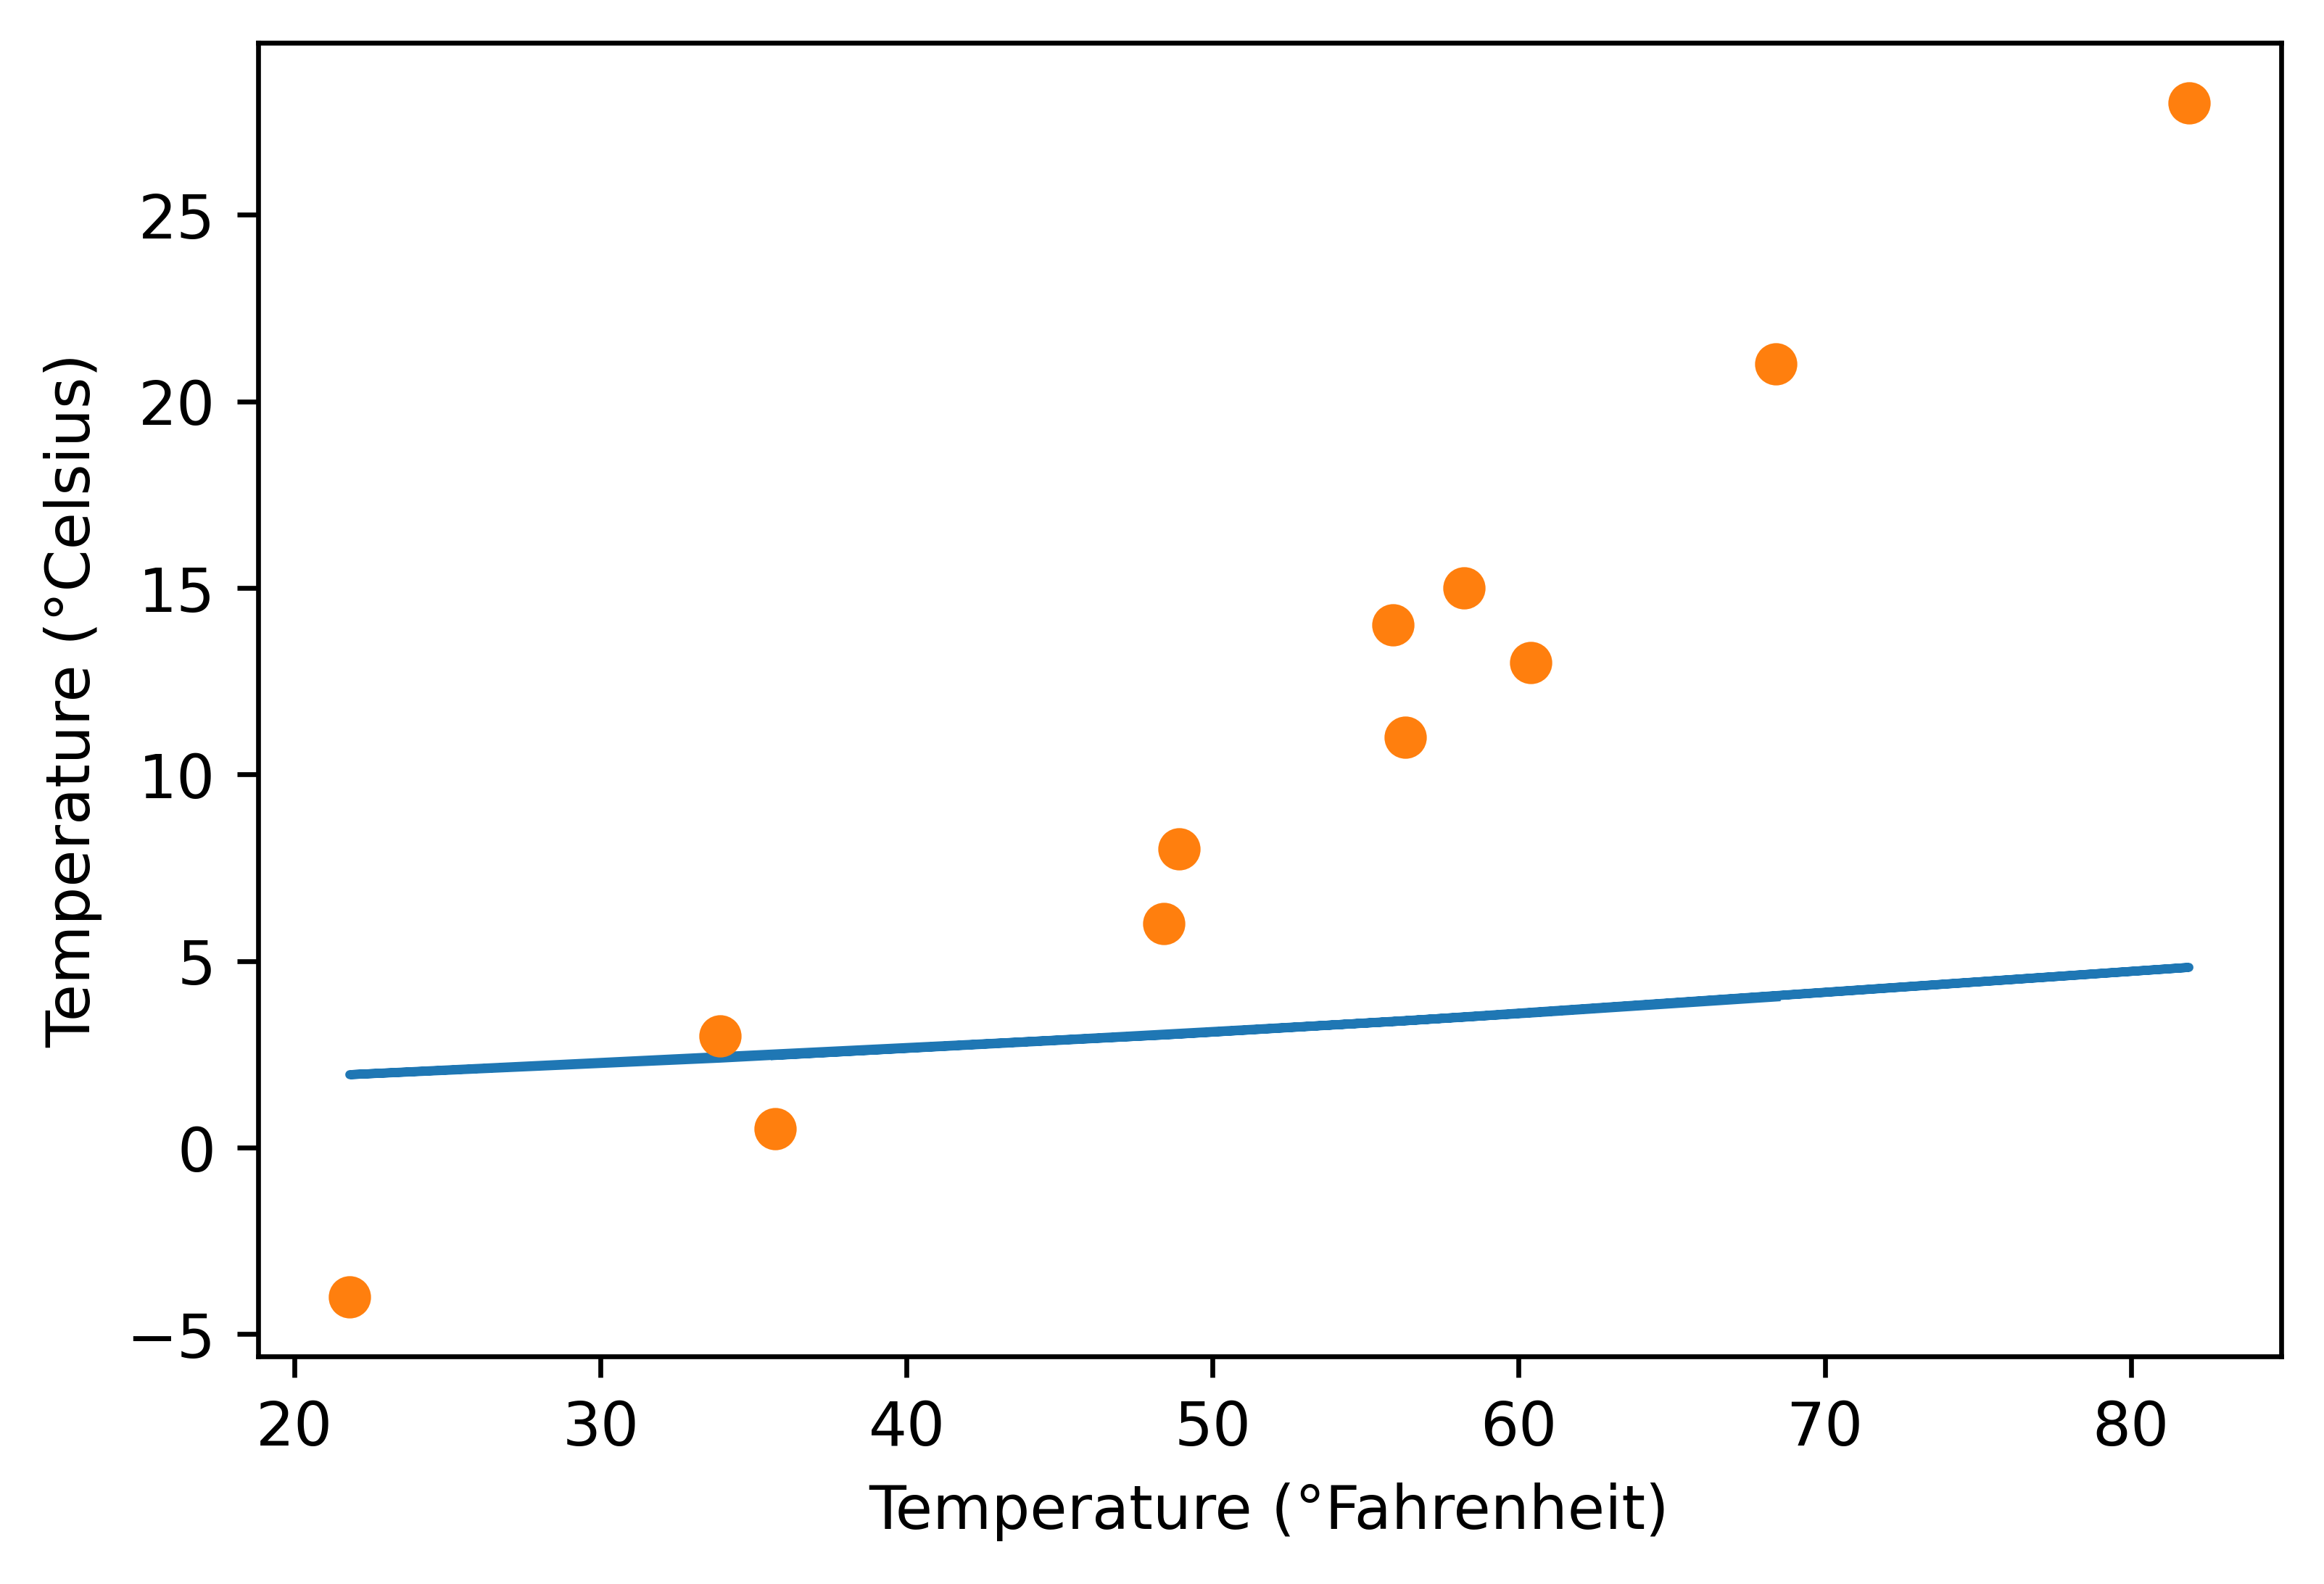

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

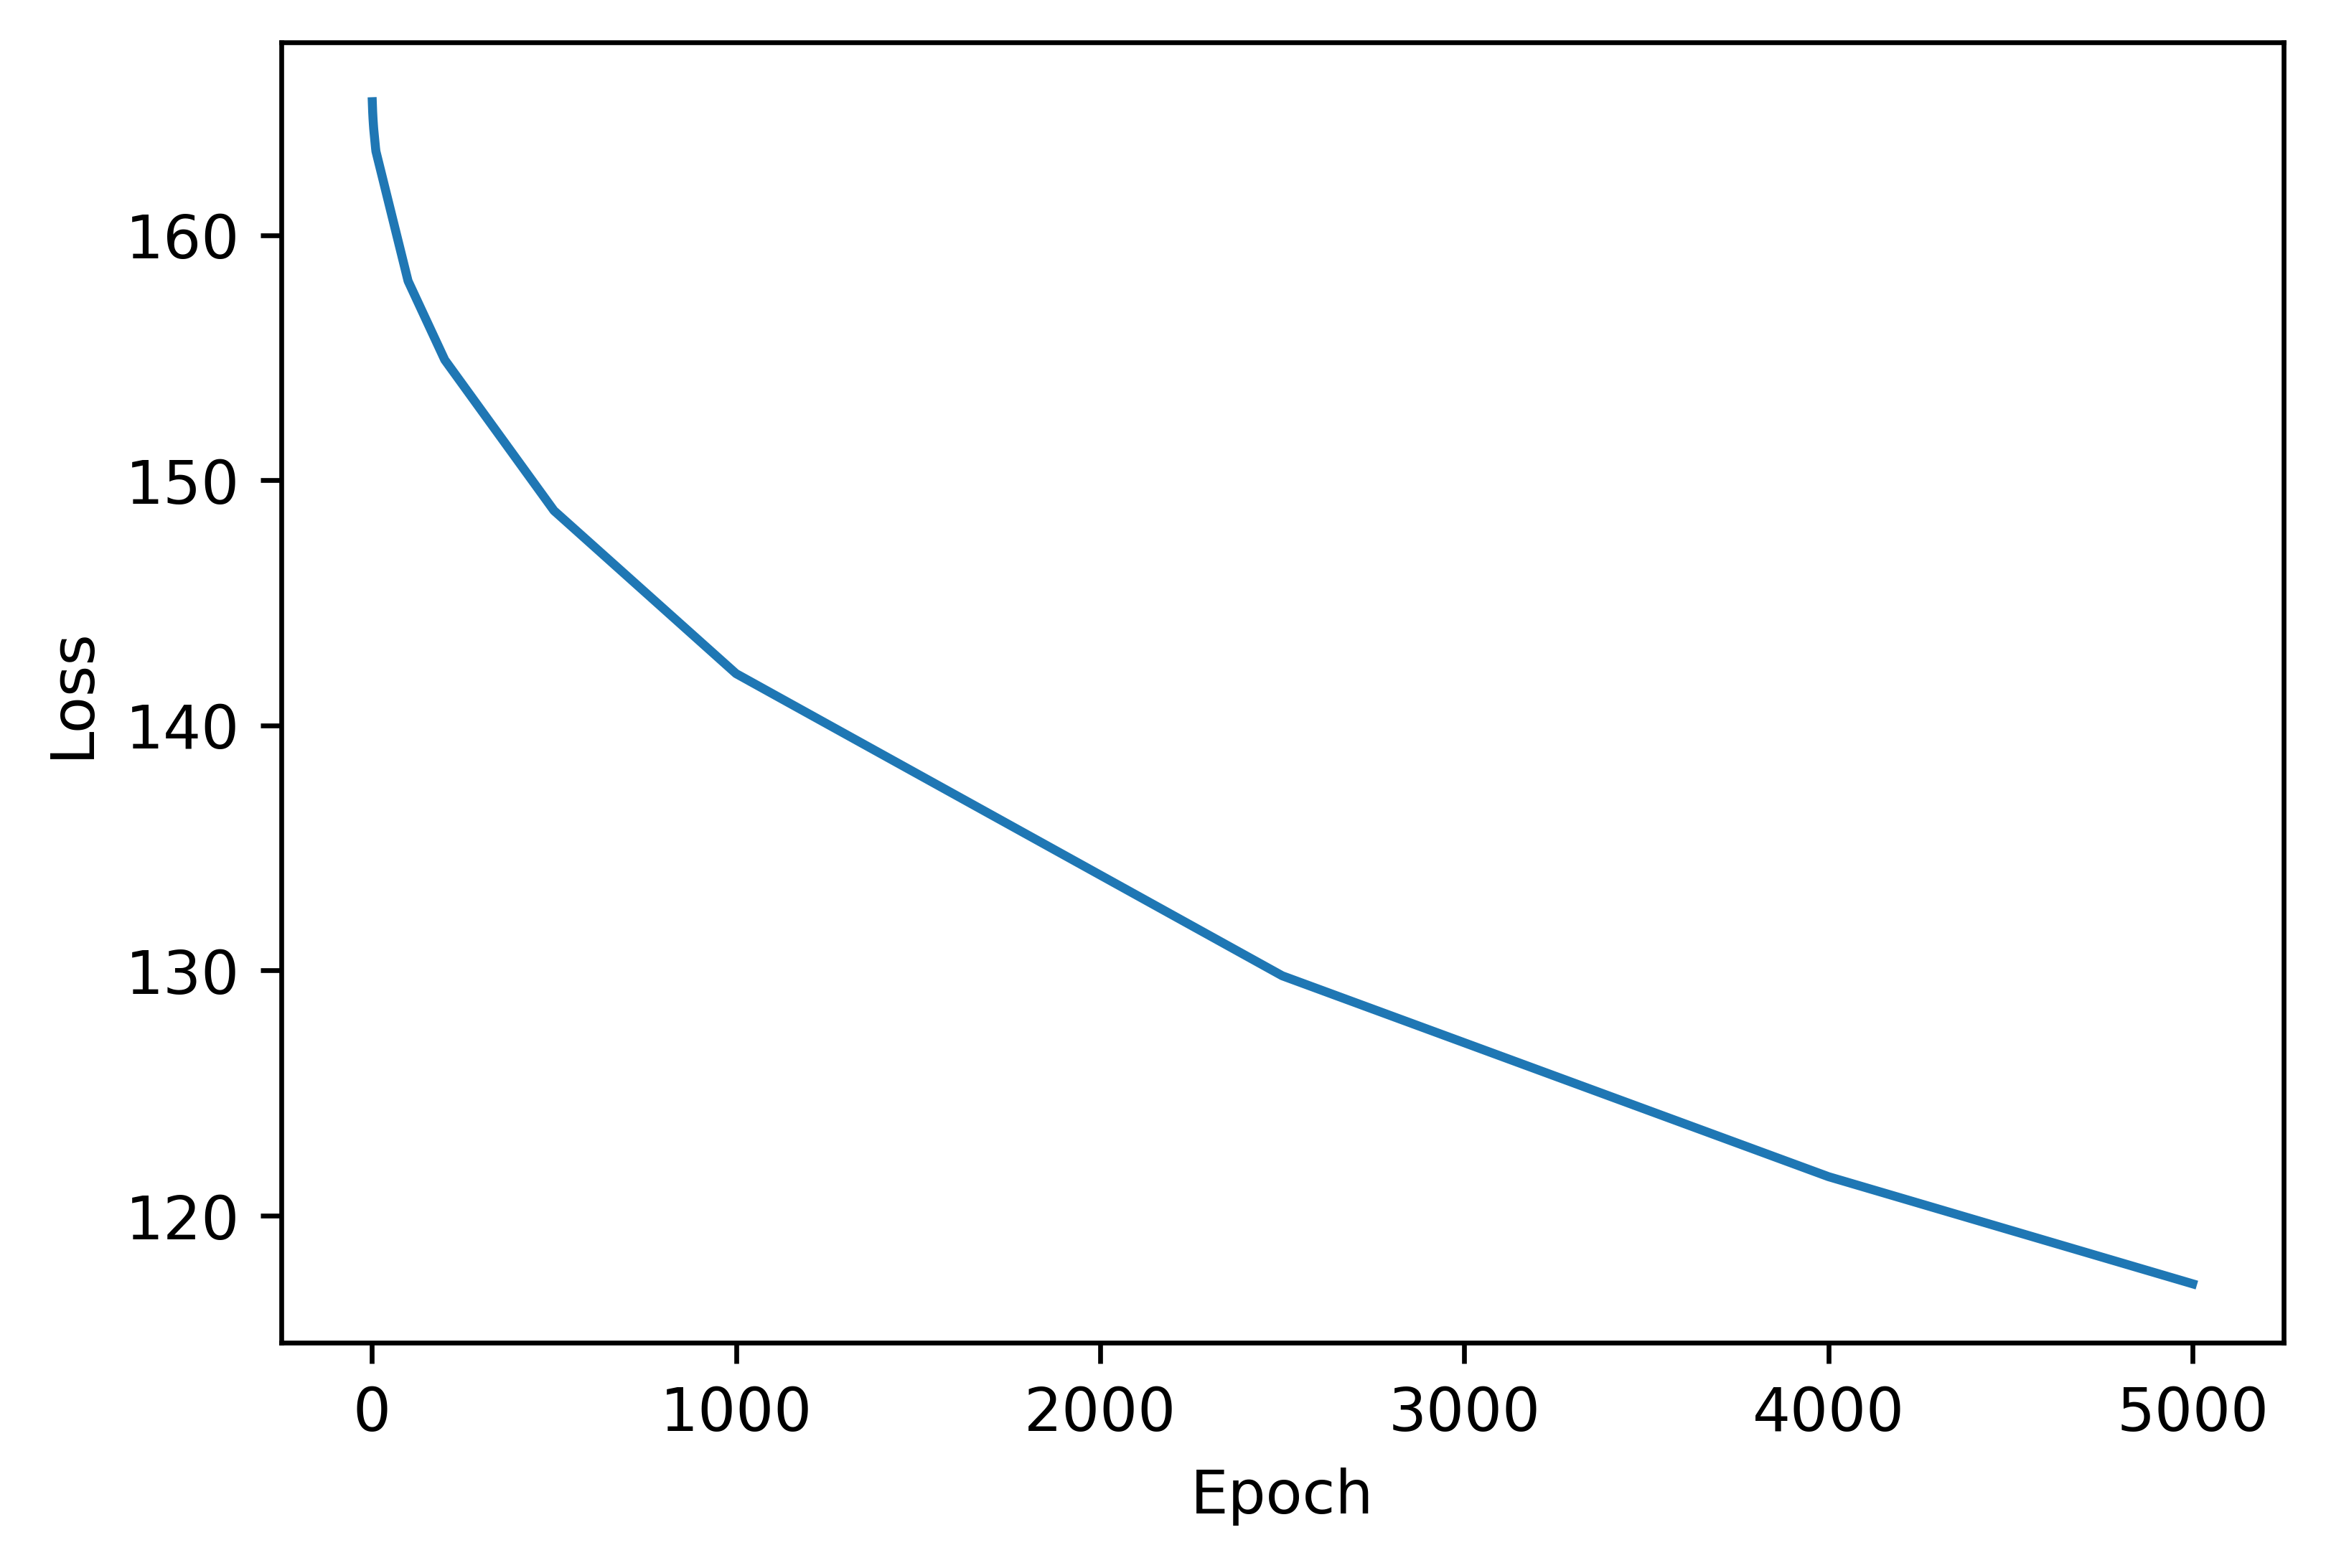

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochNum.numpy(), lossVal.numpy())

plt.savefig("temp_data_plot.png", format="png")